In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

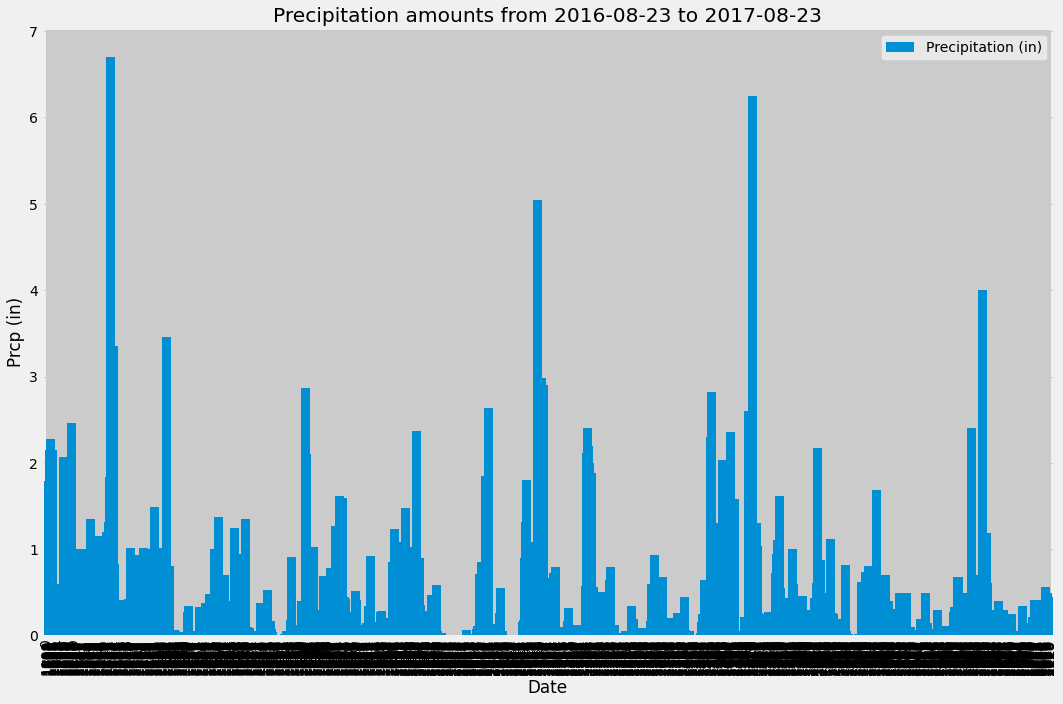

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_past = dt.date(2017, 8, 23) - dt.timedelta(days=365)



# Perform a query to retrieve the data and precipitation scores
latest_year_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_past).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
lyd_df = pd.DataFrame(latest_year_data, columns=['date', 'prcp'])

# Sort the dataframe by date
lyd_df = lyd_df.sort_values(by='date')
lyd_df


# Use Pandas Plotting with Matplotlib to plot the data
prcp_plot = lyd_df.plot(kind="bar", figsize=(15, 10), width=20)

prcp_plot.legend(["Precipitation (in)"], loc="upper right")
prcp_plot.set_xlabel("Date")
prcp_plot.set_ylabel("Prcp (in)")
prcp_plot.set_title(f"Precipitation amounts from {one_year_past} to 2017-08-23")

plt.tight_layout()

plt.savefig(f"prcp_data.png")
    
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
lyd_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset

stations = session.query(Station.station).count()
print(f"{stations} stations are available in this dataset")

9 stations are available in this dataset


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station, func.count()).\
    group_by(Measurement.station).\
    order_by(func.count().desc()).\
    all()

for station, count in station_counts:
    print(station, count)


USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station).\
        group_by(Measurement.station).\
        order_by(func.count().desc()).\
        first()
(mas_id,) = most_active_station
#print(f"The most active station is {mas_id}")

mas_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == mas_id) .\
        all()

for lowest_temp, highest_temp, avg_temp in mas_data:
    
    temperature_df = pd.DataFrame({
    "Lowest Temperature": lowest_temp,
    "Highest Temperature": highest_temp,
    "Average Temperature": avg_temp},index=[mas_id])

temperature_df

,Lowest Temperature,Highest Temperature,Average Temperature
USC00519281,54.0,85.0,71.663781


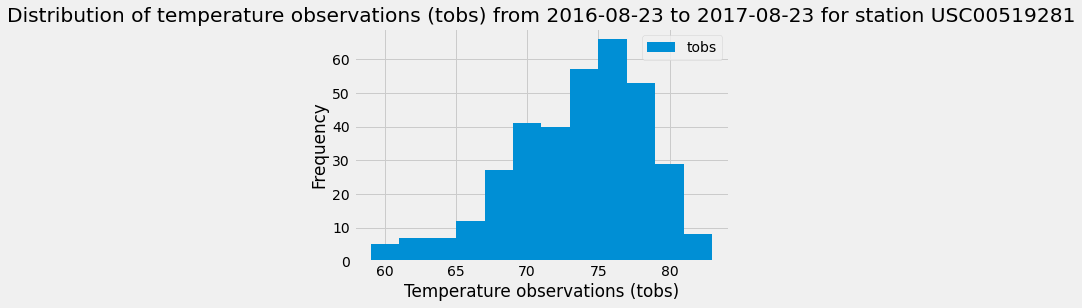

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
measurement_tuple = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
    filter(Measurement.station == mas_id).first()

last_year_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == mas_id).\
    filter(Measurement.date >= one_year_past).all()

last_year_data_df = pd.DataFrame(last_year_data, columns=['date', 'tobs'])

last_year_data_df

# plot the histogram

plt.hist(last_year_data_df["tobs"], bins=12, label="tobs")

plt.ylabel('Frequency')
plt.xlabel('Temperature observations (tobs)')
plt.title(f"Distribution of temperature observations (tobs) from {one_year_past} to 2017-08-23 for station {mas_id}")
plt.grid(zorder=0)
plt.legend(loc="upper right")

plt.savefig(f"tob_histogram.png", bbox_inches='tight')

plt.show()


# Close session

In [23]:
# Close Session
session.close()